## Testing How to draw Solutions
One question is what the weights should be. The traditional QAP formalism seems to double count weights because it uses every entry of the A,B matrices which are symmetric over the diagonal. Should I double the weights? Let's try a small example and see.

# REMOVE BEFORE PUBLISHING

In [1]:
import numpy as np
import networkx as nx
from qap_cqm import read_problem_dat
# These are the A,B matrices for tai5a
# In general B appears to be "flow" because they tend to have more zero entries

# This is a solution to tai5a as given by feasible_samples.lowest().first.sample


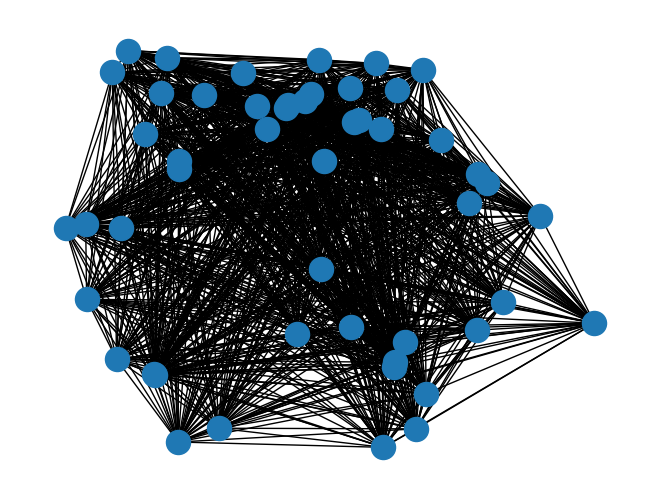

In [3]:
A, B = read_problem_dat('QAPLIB_problems/tai50a.dat')
n = len(A)
distance_edges = tuple((i,j,A[i,j]) for i in range(n) for j in range(i+1,n) if A[i,j]!= 0)
flow_edges = tuple((i,j,B[i,j]) for i in range(n) for j in range(i+1,n) if B[i,j] != 0)
shared_edges = tuple((i,j,A[i,j]*B[i,j]) for i in range(n) for j in range(i+1,n) if (A[i,j]!= 0) and B[i,j]!= 0) # only has edges where node weights are nonzero
G = nx.Graph()
# (G.add_weighted_edge(e) for e in distance_edges)
G.add_weighted_edges_from(shared_edges)
(G.add_node(i) for i in range(n))
# (G.add_weighted_edge(e) for e in flow_edges)
nx.draw(G)

{0: (0, 1), 1: (1, 2), 2: (2, 4), 3: (3, 0), 4: (4, 3)}
[(0, 1), (1, 2), (2, 4), (3, 0), (4, 3)]


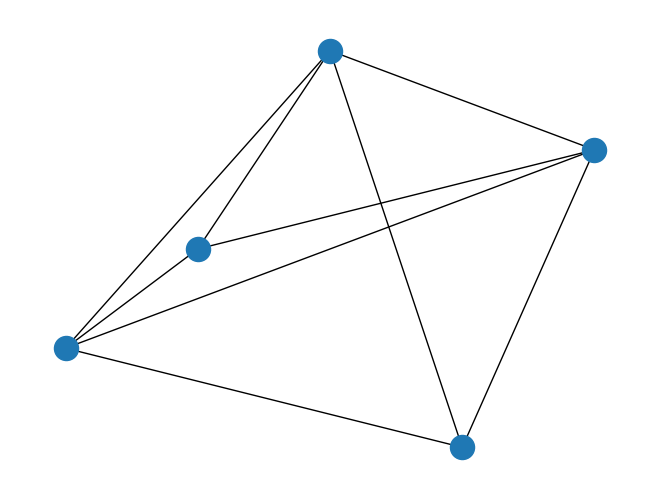

In [104]:
A, B = read_problem_dat('QAPLIB_problems/tai5a.dat')
n = len(A)
solution = {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 1.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 1.0, 15: 1.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 1.0, 24: 0.0}
positions = {}
for key in solution.keys():
    if solution[key] == 1.0:
        positions[len(positions)] = ((int(key/n),key%n))
print(positions)
# distance_edges = tuple((i,j,A[i,j]) for i in range(n) for j in range(i+1,n) if A[i,j]!= 0)
# flow_edges = tuple((i,j,B[i,j]) for i in range(n) for j in range(i+1,n) if B[i,j] != 0)
shared_edges = tuple((i,j,A[i,j]*B[i,j]) for i in range(n) for j in range(i+1,n) if (A[i,j]!= 0) and B[i,j]!= 0) # only has edges where node weights are nonzero
G = nx.Graph()
# (G.add_weighted_edge(e) for e in distance_edges)
G.add_weighted_edges_from(shared_edges)
(G.add_node(i) for i in range(n))
# (G.add_weighted_edge(e) for e in flow_edges)
nx.draw(G,pos = positions )
print(l)

In [5]:
# Copyright 2023 D-Wave Systems
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# Written by Ken Robbins & Daniel Mahler with legacy code from John McFarland

from dimod import BinaryQuadraticModel, ConstrainedQuadraticModel, Binary, BINARY, Integer, quicksum
from dwave.system import LeapHybridCQMSampler
from dwave.preprocessing.presolve import Presolver
import numpy as np
import cytoolz as tl
import click
import itertools as it
from os.path import dirname, join
import networkx as nx
import matplotlib.pyplot as plt


def read_problem_dat(path:str):
    """
    Reads the .dat files from QAPLIB and converts them to numpy arrays that describe the problem.
    A and B are (n x n)-dimensional matrices that represent either 'flow' or 'distance' in a QAP
    Inputs:
        path (str): the filepath to the dat file
    Outputs:
        A (numpy array): the flow or distance matrix for the QAP described in the .dat file
        A (numpy array): the distance or flow matrix for the QAP described in the .dat file
    """
    def read_matrix(lines):
        """ Reads a matrix printed in the .dat file and returns it as a numpy array """ 
        data = []
        for line in lines:
            data.append([int(x) for x in line.split()])
        return np.array(data)
    
    with open(path, 'r') as f:
        lines = (line.strip() for line in f)
        lines = list(line for line in lines if line)

    with open(path) as solution_file:
        n = int(solution_file.readline())
    A = read_matrix(lines[1:1+n])
    B = read_matrix(lines[1+n:])
    assert len(A) == len(B) == n
    assert np.size(A,1) == np.size(B,1) == n
    return A, B


def read_solution(filename:str):
    with open(filename) as solution_file:
        lines = solution_file.readlines()
        num_lines = len(lines)
        solution_value = int(lines[0].split(' ')[-1][:-1])
        solution_permutation = []
        for j in range(1,num_lines):
            solution_permutation += [int(i)-1 for i in lines[j].split()]
    return((solution_permutation,solution_value))


def set_qap_objective(cqm, A, B):
    """
    Writes the corresponding objective function from A and B into the CQM object
    Inputs:
        cqm (dimod.ConstrainedQuadraticModel):
        A (numpy.array): the flow or distance matrix for the QAP 
        B (numpy.array): the distance or flow matrix for the QAP
    Outputs:
        N/A 
    """
    n = len(A)
    x = [[f'x{i}_{j}' for j in range(n)] for i in range(n)]

    cqm.add_variables(BINARY, tl.concat(x))

    cqm.set_objective(
        (x0, x1, a * b)
        for (i0, x_i0), (i1, x_i1) in it.product(enumerate(x), repeat=2)
        if (a := A[i0, i1])
        for (j0, x0), (j1, x1) in it.product(enumerate(x_i0), enumerate(x_i1))
        if (b := B[j0, j1])
    )


def add_1_hot(cqm, vars, label):
    """
    Writes a one-hot constraint into the CQM object
    A one-hot constraint is such that (var_1+var_2+var_3+...+var_N = 1) for binary variables var_n
    Inputs:
        cqm (dimod.ConstrainedQuadraticModel): the CQM object representing the Quadratic Assignment Problem
        vars: the variable names that are being summed over
        label: the label for the constraint
    Outputs:
        N/A 
    `"""
    return cqm.add_constraint_from_iterable(((v, 1) for v in vars), '==', 1, label=label)


def add_discrete(cqm, vars, label):
    """
    Manually writes in a one-hot constraint to the CQM object and marks it as one-hot ("discrete")
    Faster than cqm.add_discrete for long 'vars'
    Inputs:
        cqm (dimod.ConstrainedQuadraticModel): the CQM object representing the Quadratic Assignment Problem
        vars: the variable names that are being summed over
        label: the label for the constraint
    Outputs:
        N/A 
    `"""
    lbl = add_1_hot(cqm, vars, label)
    cqm.constraints[lbl].lhs.mark_discrete()


def build_cqm(A, B, swap='auto',pre_solve:bool = True):
    """
    Constructs a CQM object which represents the Quadratic Assignment Problem.
    This includes creating variables, constructing the objective function and adding in the constraints
    Inputs:
        A (numpy.array): the flow or distance matrix for the QAP
        B (numpy.array): the distance or flow matrix for the QAP
        swap (Boolean or 'auto' = 'auto'): Whether to swap the order that the A and B matrices are checked for
                            zeros.  Most instances have a sparser "B" matrix, so we check that
                            first by default.  Instance tai256c has a sparser A matrix, so
                            'auto' swaps on that instance.
        pre_solve (Boolean = True): set to False to turn D-Wave's presolve methods off
    Outputs:
        reduced_cqm (dimod.ConstrainedQuadraticModel): a simplified CQM object representing the QAP described by A, B
    """

    
    n = len(A)
    if swap == 'auto': # The below clause forces swapping A <-> B for tai256c, the largest problem in QAPLIB
        swap = (n == 256) # tai256c is a special case with special structure in the A, B matrices
    if swap:
        tmp = A 
        A = B
        B = tmp
        del tmp

    cqm = ConstrainedQuadraticModel() # Builds an empty CQM object
    set_qap_objective(cqm, A, B) # A, B were reversed for some reason. Shouldn't matter

    x = [[f'x{i}_{j}' for j in range(n)] for i in range(n)]

    for i, row in enumerate(x):
        add_discrete(cqm, row, f'discrete_row_{i}')
    for j in range(n):
        add_1_hot(cqm, (row[j] for row in x), f'one_hot_col_{j}')
    if pre_solve==True:
        presolve = Presolver(cqm)
        presolve.load_default_presolvers()
        presolve.apply()
        reduced_cqm = presolve.detach_model()
    else:
        reduced_cqm = cqm
    return reduced_cqm

    
def relative_error_percent(observed:(int or float), expected:(int or float)):
    """
    Calculates the relative error of observed vs. expected data to 2 decimal places
    Returns the absolute value of the relative error
    """
    return(abs(np.round(100*(observed-expected)/expected,2)))


def round_decimals_up(number:float, decimals:int = 2):
    """
    Returns a value rounded UP to a specific number of decimal places.
    Used to round estimated runtime ABOVE the minimum required by the CQM sampler
    Derived from kodify.net
    """
    if decimals == 0:
        return np.ceil(number)
    factor = 10 ** decimals
    return np.ceil(number * factor) / factor



def main(filename:str, pre_solve = True, runtime = 5):
    """
    Solves the Quadratic Assignment Problem with the designated filename, then prints results and compares to QAPLIB
    Inputs:
        filename (str): the name of the QAP to read and solve, e.g. tai12a or wil100
        verbose (Boolean = True): set to False to turn off printed status updates mid-solve
        pre_solve (Boolean = True): set to False to turn D-Wave's presolve methods off
        runtime (float = 5): the runtime for the CQM sampler
            If runtime is too low then the code automatically adjusts runtime to the minimum required
    Outputs:
        (solution_value,best_value,best.sample) (tuple):
            solution_value (int): the best-known solution according to QAPLIB
            best_value (int): the best solution value from the hybrid sampler
            best.sample (dict): the best solution variables from our hybrid sampler 
                keys are variable names
                    If pre_solve == True then variable names will be integers from 0 to n**2
                    If pre_solve == False then variable names will be like 'xi_j' where 0 <= i,j < n
                values are only 0.0 or 1.0
    """
    # Read the problem and solution
    A,B = read_problem_dat(f'QAPLIB_problems/{filename}.dat') # distance and flow matrices
    n = len(A)
    solution_perm, solution_value = read_solution(f'QAPLIB_solutions/{filename}.sln')
    print(type(solution_value))

    # Build CQM object
    print('Building CQM object')
    cqm = build_cqm(A,B,pre_solve=pre_solve)

    # Specify sampler
    sampler=LeapHybridCQMSampler()

    # Pick runtime for sampler
    print('Running sampler')
    min_time = sampler.min_time_limit(cqm) # Estimates the minimum recommended time for the CQM sampler
    if not runtime:
        if min_time >= 5:
            new_time_spent = round_decimals_up(min_time,1)
            print(f'Adjusting runtime to minimum required: {new_time_spent}s\n')
        else:
            new_time_spent = 5
    elif runtime >= min_time: # If manual runtime is more than minimum runtime
        new_time_spent = runtime
        print(f'Runtime is manually set to {new_time_spent}s\n')
    else: # If manual runtime is less than minimum runtime
        new_time_spent = round_decimals_up(min_time,1)

    # Run the sampler
    sample_set = sampler.sample_cqm(cqm, time_limit = new_time_spent)

    # Filter the solutions
    feasible_samples = sample_set.filter(lambda d: d.is_feasible)
    
    # Analyze the solution and print results
    if len(feasible_samples)>0:
        best = feasible_samples.lowest().first
        best_value = best.energy
        if best_value == int(best_value):
            best_value = int(best_value)
        print(f'\nFeasible solution found!\nThe total cost of the solution is {best_value}')
        if (best_value == solution_value):
            print('This is the same value as the best-known solution according to QAPLIB.\n')
        elif (best_value > solution_value):
            print(f'This is a {relative_error_percent(best_value,solution_value)}% higher solution from the best-known solution on QAPLIB: {solution_value}\n')
        elif (best_value < solution_value):
            print(f'This is a {relative_error_percent(best_value,solution_value)}% better value than the best-known solution on QAPLIB: {solution_value}\n')
        return((solution_value,best_value,best.sample,A,B,solution_perm))

    else:
        print(f'No feasible solution found after {new_time_spent}s')
        print(f'Try manually increasing the runtime for the LeapHybridCQMSampler with the \"--runtime\" option\n')




<class 'int'>
Building CQM object
Running sampler
Runtime is manually set to 5s


Feasible solution found!
The total cost of the solution is 224416
This is the same value as the best-known solution according to QAPLIB.



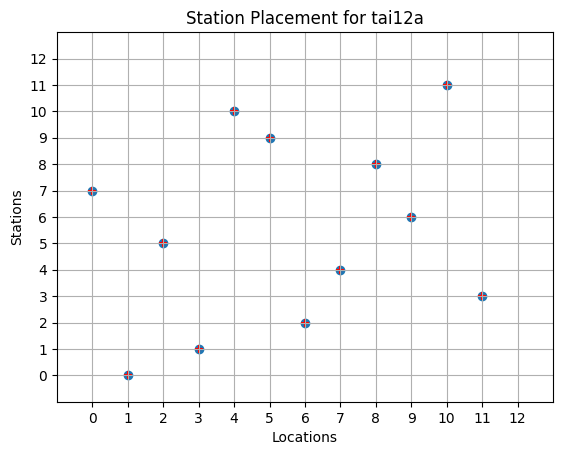

In [6]:
filename = 'tai12a'
result = main(filename)
solution = result[2]
A = result[3]
B = result[4]
solution_perm = result[5]
n = len(A)
vals = list(solution.values())
x_positions = [int(j/n) for j in range(len(vals)) if vals[j] == 1.0]
y_positions = [j%n for j in range(len(vals)) if vals[j] == 1.0]
best_known_x_positions = range(n)
best_known_y_positions = solution_perm
plt.grid(True)
plt.xlabel('Locations')
plt.ylabel('Stations')
plt.title(f'Station Placement for {filename}')
if n <= 15:
    grid_spacing = 1
else:
    grid_spacing = np.ceil(n/10)
plt.xticks(np.arange(0, n+1, grid_spacing))
plt.yticks(np.arange(0, n+1, grid_spacing))
plt.xlim(-1,n+1)
plt.ylim(-1,n+1)
plt.scatter(x_positions,y_positions)
plt.scatter(best_known_x_positions,best_known_y_positions,marker = '+', color = 'red')
plt.savefig(f'{filename}_solution_plot.png')

<class 'int'>
Building CQM object
Running sampler
Runtime is manually set to 5s


Feasible solution found!
The total cost of the solution is 1827810
This is a 0.53% higher solution from the best-known solution on QAPLIB: 1818146



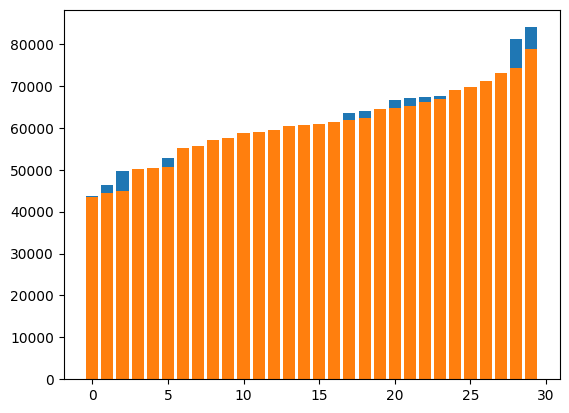

In [83]:
filename = 'tai30a'
result = main(filename)
solution = result[2]
A = result[3]
B = result[4]
solution_perm = result[5]
def nvec(n,ind):
    out = np.zeros(n)
    out[ind] = 1
    return(out)
def nmat(vec): # Should this be transposed? writes best solution perm matrix from solution_perm
    n = len(vec)
    return(np.array([nvec(n,k) for k in vec]))
best_matrix = nmat(solution_perm)

solution_value = read_solution(f'QAPLIB_solutions/{filename}.sln')[1]
n = len(A)

def cost_list(A,B,solmat):
    return(np.array(list(sum(A[j,k]*B[l,m]*solmat[j,l]*solmat[k,m] for k in range(n) for l in range(n) for m in range(n)) for j in range(n))))

best_sizes = cost_list(A,B,best_matrix)
solumat= np.array(list(solution.values())).reshape(n,n)
sol_sizes = cost_list(A,B, solumat)
best_sizes.sort()
sol_sizes.sort()
plt.bar(range(n),sol_sizes)
plt.bar(range(n),best_sizes)
plt.show()


Define alpha_{jm} as the sum over k of A_{jk}x_{km}. Define beta_{jm} as the sum over l of x_{jl}B(l). The total cost is equal to the sum over j and m of alpha_{jm}beta_{jm}

Cost associated with location j and factory m is alpha_{jm}beta_{jm}

<class 'int'>
Building CQM object
Running sampler
Runtime is manually set to 5s


Feasible solution found!
The total cost of the solution is 648704420
This is a 1.8% higher solution from the best-known solution on QAPLIB: 637250948



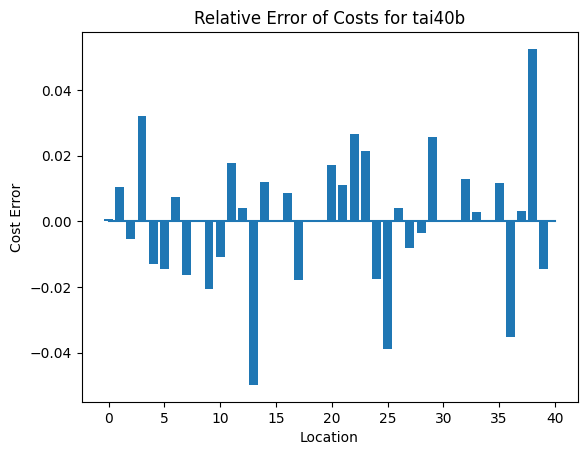

In [107]:
filename = 'tai40b'
result = main(filename)
solution = result[2]
A = result[3]
B = result[4]
solution_perm = result[5]

def bar_plotter(A,B,best_solution,hybrid_solution):
    n = len(A)
    def nvec(n,ind):
        out = np.zeros(n)
        out[ind] = 1
        return(out)
    def nmat(vec): # Should this be transposed? writes best solution perm matrix from solution_perm
        n = len(vec)
        return(np.array([nvec(n,k) for k in vec]))
    def cost_list(A,B,solmat):
        return(np.array(list(sum(A[j,k]*B[l,m]*solmat[j,l]*solmat[k,m] for k in range(n) for l in range(n) for m in range(n)) for j in range(n))))
    best_matrix = nmat(best_solution)
    hybrid_matrix = np.array(list(hybrid_solution.values())).reshape(n,n)
    best_cost_list = cost_list(A,B, best_matrix)
    hybrid_cost_list = cost_list(A,B,hybrid_matrix)
    plt.bar(range(n),(hybrid_cost_list-best_cost_list)/sum(best_cost_list), label = 'Normalized error of locations\' cost')
    plt.plot([0,n],[0,0])
    plt.xlabel('Location')
    plt.ylabel('Cost Error')
    plt.title(f'Normalized Error of Costs for {filename}')
    plt.show()

bar_plotter(A,B,solution_perm,solution)

